In [1]:
from glob import glob 
import numpy as np
import pandas as pd
import keras,cv2,os
import gc
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from tqdm import tqdm_notebook,trange
from tqdm import tqdm

In [2]:
path = "data/histopathologic-cancer-detection/" 
train_path = path + 'train/'
test_path = path + 'test/'

# Creating a dataframe of data locations and ids

In [3]:
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))})

In [4]:
df['id'] = df['path'].map(lambda x: x[:-4].split("/")[-1])

In [5]:
df.head()

,path,id
0,data/histopathologic-cancer-detection/train/f0...,f0c2a0b8ef3024f407fa97d852d49be0215cafe0
1,data/histopathologic-cancer-detection/train/99...,99ef485f205645918613cd04281098daa7c17819
2,data/histopathologic-cancer-detection/train/e2...,e2612e173abd0e8bb54a3c3db3f264b63d80bffb
3,data/histopathologic-cancer-detection/train/6d...,6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0
4,data/histopathologic-cancer-detection/train/9c...,9c043ab2adadfeb758c71d21432fccd3e43565c0


In [6]:
labels = pd.read_csv(path+"train_labels.csv")
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [7]:
df = df.merge(labels, on = "id") 

In [8]:
df.head()

,path,id,label
0,data/histopathologic-cancer-detection/train/f0...,f0c2a0b8ef3024f407fa97d852d49be0215cafe0,0
1,data/histopathologic-cancer-detection/train/99...,99ef485f205645918613cd04281098daa7c17819,1
2,data/histopathologic-cancer-detection/train/e2...,e2612e173abd0e8bb54a3c3db3f264b63d80bffb,1
3,data/histopathologic-cancer-detection/train/6d...,6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0,0
4,data/histopathologic-cancer-detection/train/9c...,9c043ab2adadfeb758c71d21432fccd3e43565c0,1


# Some Data Visualizations


#### Distribution of Labels

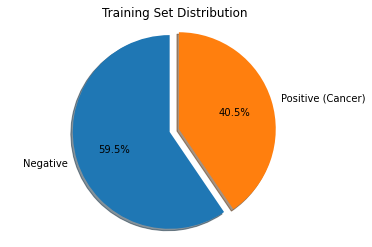

In [9]:
labels = 'Negative', 'Positive (Cancer)'
sizes = [(df['label'] ==0).sum(), (df['label'] ==1).sum()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Training Set Distribution")
plt.show()

### Viewing some of the images

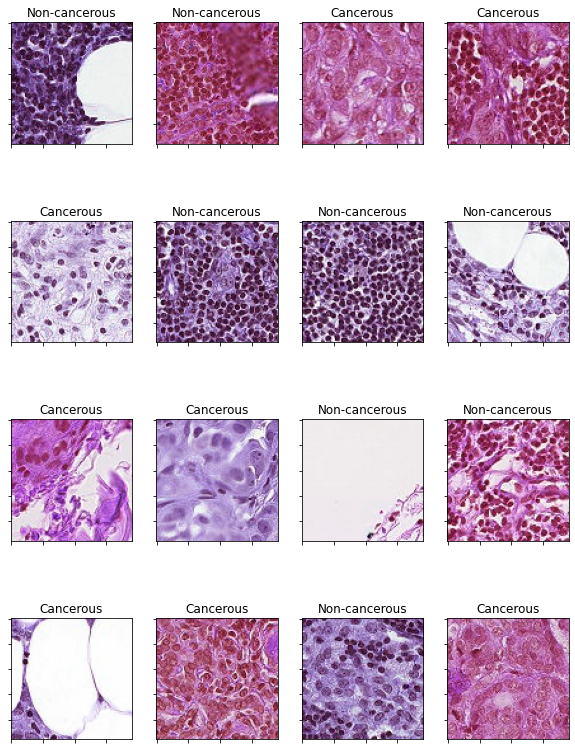

<Figure size 1500x2100 with 0 Axes>

In [10]:

import random
randomlist = np.array(random.sample(range(0, df.shape[0]), 16)).reshape(4,4)
fig, axs = plt.subplots(4, 4, figsize = (10,14))
fig = plt.figure(figsize=(10, 14), dpi=150)

for i in range(4):
    for j in range(4):
        axs[i,j].imshow(cv2.imread(df['path'][randomlist[i,j]]))
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])
        if df['label'][randomlist[i,j]] == 0:
            axs[i,j].set_title("Non-cancerous")
        else:
            axs[i,j].set_title("Cancerous")
            
plt.show()        

# Loading And Splitting the Data

In [11]:
def load_data(N,df):
    """
    loads in first N rows of the dataframe df
    returns: X: np array of  N images, where  X.shape = (N, 96,96,3) 
             y:  np array of N labels, where y.shape = (N, )
    """
    y = np.array(df['label'])[:N]
    X = np.zeros([N,96,96,3]) 
#     in tqdm_notebook(df.iterrows(), total=N)

    for i in tqdm(range(N)):
        X[i] =  cv2.imread(df['path'][i])
    return X, y

In [43]:
X,y = load_data(100000, df)

100%|██████████| 100000/100000 [02:07<00:00, 784.46it/s]


In [44]:
print(f'The shape of X is {X.shape}')
print(f"The shape of y is {y.shape}")

The shape of X is (100000, 96, 96, 3)
The shape of y is (100000,)


In [45]:
def split_data(mat, target, train_ratio):
    # Get the number of rows in the training data
    train_rows = int(len(mat) * train_ratio)
    print('got the number of rows to train')
    # Place the first `train_rows` shuffled rows into the training data 
    # and the remaining rows into the test data
    rng = np.random.default_rng(1)
    
    shuffled_indices = np.arange(len(mat))
    print('got shuffled indices')
    # print(shuffled_indices)
    rng.shuffle(shuffled_indices)
    # print(type(shuffled_indices[:train_rows]))
    print('shuffled shuffled_indices')
    X_train = np.array([mat[i] for i in shuffled_indices[:train_rows]])
    print('got Xtrain')
    X_test  = np.array([mat[i] for i in shuffled_indices[train_rows:]])
    print('got Xtest')
    Y_train = target[shuffled_indices[:train_rows]]
    print('got ytrain')
    Y_test  = target[shuffled_indices[train_rows:]]
    print('got ytest')
    return X_train, X_test, Y_train, Y_test

In [46]:
Xtrain,Xtest, ytrain, ytest = split_data(X,y, 0.8)

got the number of rows to train
got shuffled indices
shuffled shuffled_indices
got Xtrain
got Xtest
got ytrain
got ytest


# The AlexNet Model 

In [47]:

kernel_size = (3,3)
pool_size= (2,2)
first_filter = 32
second_filter = 64
third_filter = 128

dropout_conv = 0.3
dropout_dense = 0.5
class AlexNet(Sequential):
    def __init__(self, input_shape):
        super().__init__()
        #layer 1
        self.add(Conv2D(first_filter, kernel_size, input_shape = input_shape))
        self.add(BatchNormalization())
        self.add(MaxPool2D(pool_size=pool_size))
        self.add(Dropout(dropout_conv))

        #layer 2
        self.add(Conv2D(second_filter, kernel_size=kernel_size, use_bias = False ))
        self.add(BatchNormalization())
        self.add(Activation("relu"))
        self.add(MaxPool2D(pool_size = pool_size)) 
        self.add(Dropout(dropout_conv))
        
        #layer 3
        self.add(Conv2D(third_filter, kernel_size, use_bias=False))
        self.add(BatchNormalization())
        self.add(Activation("relu"))
        self.add(MaxPool2D(pool_size = pool_size)) 
        self.add(Dropout(dropout_conv))

        #end layer
        self.add(Flatten())
        self.add(Dense(256, use_bias=False))
        self.add(BatchNormalization())
        self.add(Activation("relu"))
        self.add(Dropout(dropout_dense))
        self.add(Dense(1, activation = "sigmoid"))
       
    
        self.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])


### Instantiating Model and Summarizing its Architeture

In [48]:
model = AlexNet((96, 96, 3))
model.summary()

Model: "alex_net_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 45, 45, 64)        18432     
_________________________________________________________________
batch_normalization_13 (Batc (None, 45, 45, 64)        256       
_________________________________________________________________
activation_9 (Activation)    (None, 45, 45, 64)        0

### Fitting the Model

In [49]:
# training the model
model.fit(
    Xtrain,
    ytrain,
    batch_size=50,
    epochs=4,
    validation_data=(Xtest, ytest), verbose = 1
)

Epoch 1/4
1600/1600 [==============================] - 886s 550ms/step - loss: 0.4754 - accuracy: 0.7913 - val_loss: 0.6139 - val_accuracy: 0.6973
Epoch 2/4
1600/1600 [==============================] - 789s 493ms/step - loss: 0.3714 - accuracy: 0.8415 - val_loss: 0.3653 - val_accuracy: 0.8441
Epoch 3/4
1600/1600 [==============================] - 772s 482ms/step - loss: 0.3456 - accuracy: 0.8511 - val_loss: 0.4330 - val_accuracy: 0.8265
Epoch 4/4
1600/1600 [==============================] - 741s 463ms/step - loss: 0.3258 - accuracy: 0.8619 - val_loss: 0.4956 - val_accuracy: 0.7964


In [42]:
# model.save('model_10000')
"""
model_10000:

Epoch 1/4
160/160 [==============================] - 98s 499ms/step - loss: 0.5842 - accuracy: 0.7395 - val_loss: 1.0025 - val_accuracy: 0.6065
Epoch 2/4
160/160 [==============================] - 96s 602ms/step - loss: 0.4633 - accuracy: 0.7985 - val_loss: 2.0000 - val_accuracy: 0.6015
Epoch 3/4
160/160 [==============================] - 88s 547ms/step - loss: 0.4168 - accuracy: 0.8211 - val_loss: 0.5049 - val_accuracy: 0.7705
Epoch 4/4
160/160 [==============================] - 96s 600ms/step - loss: 0.3900 - accuracy: 0.8308 - val_loss: 0.6086 - val_accuracy: 0.7210
"""

INFO:tensorflow:Assets written to: model_10000/assets


In [50]:
model.save('model_100000')

INFO:tensorflow:Assets written to: model_100000/assets
